In [1]:
# ================================================================
# SIMPLE MOE IMPLEMENTATION
# ================================================================
"""
GOAL: Build MoE with 3 experts and verify it matches the baseline ~97.5%

COMPONENTS: 
    1 - Expert Network (small MLP)
    2 - Gating Network (routing logic)
    3 - MoE Layer (combines gating + experts)
"""

# ================================================================
# IMPORTS AND SETUP
# ================================================================

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm 
import time 
from collections import defaultdict, Counter

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 5)

# Set random seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

print("="*60)
print("DAY 10: MIXTURE-OF-EXPERTS IMPLEMENTATION")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("="*60)

DAY 10: MIXTURE-OF-EXPERTS IMPLEMENTATION
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
# ================================================================
# DATA LOADING (SAME AS 01_moe_baseline)
# ================================================================

def load_mnist(batch_size=64, data_dir='/kaggle/working/data'):
    """Load MNIST dataset."""
    print("\nLoading MNIST Dataset...")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=2, pin_memory=True)
    
    print(f"✓ Training samples: {len(train_dataset):,}")
    print(f"✓ Test samples: {len(test_dataset):,}")
    
    return train_loader, test_loader

In [3]:
# ================================================================
# EXPERT NETWORK
# ================================================================

class Expert(nn.Module):
    """
    Single expert in the MoE

    An expert is just a small MLP. The magic happens when we combine 
    multiple experts with intelligent routing (gating)

    Architechture: 
        Input -> Hidden -> ReLU -> Output

    This is smaller than the baseline MLP as we will have multiple experts
    working together
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()

        # Two-layer MLP
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

        # Track which expert this is (necessary for debugging)
        self.expert_id = None

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Xavier Initialization
        """
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        """
        Forward pass through expert

        Args: 
            x: Input tensor (batch, input_dim)

        Returns: 
            Output tensor (batch, output_dim)
        """
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [4]:
# ================================================================
# GATING NETWORK
# ================================================================

class GatingNetwork(nn.Module):
    """
    Decides which expert/experts to use for each input

    This is where the "intelligence" of MoE lives

    How it works: 
        1 - Takes inout features
        2 - Outputs a score for each expert
        3 - Applies softmax -> probabilities
        4 - Selects top-k experts
        5 - Renormalizes selected gates

    Note: 
        The gating network LEARNS during the training which expert 
        should handle which inputs.
    """
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()

        # Single linear layer: input -> expert scores
        self.fc = nn.Linear(input_dim, num_experts)
        self.num_experts = num_experts

        # Initialize 
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x, top_k = 1):
        """
        Comput gating decisions

        Args: 
            x: Input tensor (batch, input_dim)
            top_k: Number of experts to select (1 -> use the best expert only)

        Returns: 
            top_indices: (batch, top_k) - which experts to use
            top_gates: (batch, top_k) - weights for each selected expert
            all_gates: (batch, num_experts) - probabilities for all experts
        """
        # Get the logits for each expert
        logits = self.fc(x) # (batch, num_experts)

        # Convert to probs
        all_gates = F.softmax(logits, dim=1) # (batch, num_experts)

        # Select top-k experts
        # top_gates: (batch, top_k) - gate values for selected experts
        # top_indices: (batch, top_k) - which experts were selected
        top_gates, top_indices = torch.topk(all_gates, top_k, dim=1)

        # Renormalize selected gates
        # After selecting the top-k, gates do not sum to 1
        # Therefore this step 
        top_gates = top_gates / (top_gates.sum(dim=1, keepdim=True) + 1e-10)

        return top_indices, top_gates, all_gates
        

In [5]:
# ================================================================
# MIXTURE-OF-EXPERTS LAYER
# ================================================================

class SimpleMoE(nn.Module):
    """
    Mixture-of-Experts Layer (without load balancing)
    Combines gating + experts

    How it works: 
         1 - Input goes to gating network
         2 - gating selects which expert/experts to use
         3 - Selected expert/experts process the input
         4 - Outputs are combined using gating weights

    Example with 3 experts, top_k = 1:
        - Input: Image of "4"
        - Gating "Use Expert 2" (weight = 1.0)
        - Expert 2 processes image
        - Ouput: Prediction for "4"
    """
    def __init__(self, input_dim, num_experts=3, expert_hidden=64, output_dim=10, top_k=1):
        super(SimpleMoE, self).__init__()

        self.num_experts = num_experts
        self.top_k = top_k
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Create the Gating Network
        self.gating = GatingNetwork(input_dim, num_experts)

        # Create Experts
        self.experts = nn.ModuleList([
            Expert(input_dim, expert_hidden, output_dim) for i in range(num_experts)
        ])

        # Assign IDs to experts (for tracking)
        for i, expert in enumerate(self.experts):
            expert.expert_id = i

        # Track expert usage
        self.expert_counts = torch.zeros(num_experts)

    def forward(self, x):
        """
        Forward pass through MoE

        Args:
            x: Input (batch, input_dim) - flattened images

        Returns: 
            output: (batch, output_dim) - predictions
            aux_loss: Placeholder (will add load balancing ahead)
        """
        batch_size = x.size(0)

        # Flatten
        if x.dim() > 2:
            x = x.view(batch_size, -1)

        # Get gating decisions
        top_indices, top_gates, all_gates = self.gating(x, self.top_k)

        # Initialize output
        output = torch.zeros(batch_size, self.output_dim).to(x.device)

        # Route to experts
        for k in range(self.top_k):
            # Get the expert indices and weights for position k
            expert_idx = top_indices[:, k]
            gate_weight = top_gates[:, k]

            # Process each expert
            for expert_id in range(self.num_experts):
                # Find samples that will go to this expert
                mask = (expert_idx == expert_id)

                if mask.any():
                    # Get inputs for this expert
                    expert_input = x[mask]

                    # Run through the expert
                    expert_output = self.experts[expert_id](expert_input)

                    # Add weighted output to final result
                    # gate_weight determines how much this expert contributes
                    output[mask] += gate_weight[mask].unsqueeze(1) * expert_output

                    # Track usage
                    self.expert_counts[expert_id] += mask.sum().item()

        # Placeholder for load balancing loss (implement later)
        aux_loss = torch.tensor(0.0).to(x.device)

        return output, aux_loss

    def count_parameters(self):
        """Count trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def get_expert_utilization(self):
        """
        Get expert utilization statistics.
        
        Returns:
            dict with expert usage info
        """
        total = self.expert_counts.sum()
        if total == 0:
            percentages = [0.0] * self.num_experts
            entropy = 0.0
        else:
            percentages = (self.expert_counts / total * 100).tolist()
            
            # Compute entropy (higher = more balanced)
            probs = self.expert_counts / total
            # Add small epsilon to avoid log(0)
            entropy = -(probs * torch.log(probs + 1e-10)).sum().item()
        
        return {
            'counts': self.expert_counts.tolist(),
            'percentages': percentages,
            'entropy': entropy,
            'max_usage': max(percentages) if percentages else 0,
            'min_usage': min(percentages) if percentages else 0
        }
    
    def reset_expert_counts(self):
        """Reset expert usage tracking."""
        self.expert_counts = torch.zeros(self.num_experts)
                

In [6]:
# ================================================================
# SECTION 6: TRAINING FUNCTIONS
# ================================================================

def train_epoch_moe(model, train_loader, optimizer, criterion, device, epoch):
    """
    Train MoE for one epoch.
    """
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass (returns output + aux_loss)
        output, aux_loss = model(data)
        
        # Task loss (classification)
        task_loss = criterion(output, target)
        
        # Total loss (for now, just task loss since no load balancing)
        total_loss_batch = task_loss  
        
        # Backward
        total_loss_batch.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += task_loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)
        
        pbar.set_postfix({
            'loss': f'{task_loss.item():.4f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    avg_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return avg_loss, train_acc


def evaluate_moe(model, test_loader, criterion, device):
    """
    Evaluate MoE on test set.
    """
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output, _ = model(data)
            test_loss += criterion(output, target).item()
            
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc


def train_moe(model, train_loader, test_loader, epochs=10, lr=0.001, device='cuda'):
    """
    Complete training loop for MoE.
    """
    print("\nTraining MoE...")
    print(f"Model parameters: {model.count_parameters():,}")
    print(f"Number of experts: {model.num_experts}")
    print(f"Top-k selection: {model.top_k}")
    print(f"Device: {device}")
    print("-" * 60)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    model = model.to(device)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'expert_utilization': [],
        'epoch_times': []
    }
    
    best_acc = 0
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        
        # Reset expert counts for this epoch
        model.reset_expert_counts()
        
        # Train
        train_loss, train_acc = train_epoch_moe(
            model, train_loader, optimizer, criterion, device, epoch
        )
        
        # Evaluate
        test_loss, test_acc = evaluate_moe(model, test_loader, criterion, device)
        
        # Get expert utilization
        util = model.get_expert_utilization()
        
        epoch_time = time.time() - start_time
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['expert_utilization'].append(util)
        history['epoch_times'].append(epoch_time)
        
        # Print summary
        print(f"\nEpoch {epoch}/{epochs} Summary:")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"   Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.2f}%")
        print(f"   Expert Usage: {[f'{p:.1f}%' for p in util['percentages']]}")
        print(f"   Entropy: {util['entropy']:.3f} (higher = more balanced)")
        print(f"   Time: {epoch_time:.1f}s")
        
        if test_acc > best_acc:
            best_acc = test_acc
            print(f"New best accuracy!")
        
        print("-" * 60)
    
    print("\nTraining Complete!")
    print(f"Final Test Accuracy: {history['test_acc'][-1]:.2f}%")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"Baseline Target: 97.5%")
    
    if history['test_acc'][-1] >= 96.5:
        print("SUCCESS: MoE matches baseline!")
    else:
        print("MoE underperforming - may need tuning")
    
    return history

In [7]:
# ================================================================
# SECTION 7: VISUALIZATION
# ================================================================

def plot_moe_analysis(history, save_path='/kaggle/working/moe_results.png'):
    """
    Create comprehensive MoE visualization.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Accuracy comparison
    axes[0].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
    axes[0].plot(epochs, history['test_acc'], 'r-s', label='Test Acc', linewidth=2)
    axes[0].axhline(y=97.5, color='green', linestyle='--', 
                    label='Baseline (97.5%)', alpha=0.7, linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('MoE Performance', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([90, 100])
    
    # Plot 2: Expert utilization over time
    num_experts = len(history['expert_utilization'][0]['percentages'])
    for expert_id in range(num_experts):
        percentages = [
            epoch_util['percentages'][expert_id]
            for epoch_util in history['expert_utilization']
        ]
        axes[1].plot(epochs, percentages, marker='o', label=f'Expert {expert_id}', linewidth=2)
    
    axes[1].axhline(y=100/num_experts, color='black', linestyle='--',
                    label='Balanced', alpha=0.5, linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Utilization (%)', fontsize=12)
    axes[1].set_title('Expert Utilization (Watch for Collapse!)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 100])
    
    # Plot 3: Gating entropy
    entropies = [util['entropy'] for util in history['expert_utilization']]
    axes[2].plot(epochs, entropies, 'purple', marker='o', linewidth=2)
    axes[2].set_xlabel('Epoch', fontsize=12)
    axes[2].set_ylabel('Entropy', fontsize=12)
    axes[2].set_title('Gating Entropy (Lower = More Collapsed)', fontsize=14, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nPlot saved to: {save_path}")
    plt.show()


def print_moe_summary(history, baseline_acc=97.5):
    """Print comprehensive MoE summary."""
    print("\n" + "="*60)
    print("SIMPLE MOE - FINAL SUMMARY")
    print("="*60)
    
    final_util = history['expert_utilization'][-1]
    
    print(f"\nPerformance vs Baseline:")
    print(f"   MoE Test Accuracy:     {history['test_acc'][-1]:.2f}%")
    print(f"   Baseline Accuracy:     {baseline_acc:.2f}%")
    print(f"   Difference:            {history['test_acc'][-1] - baseline_acc:+.2f}%")
    
    print(f"\nExpert Utilization:")
    for i, pct in enumerate(final_util['percentages']):
        print(f"   Expert {i}: {pct:5.1f}%")
    print(f"   Entropy:   {final_util['entropy']:.3f}")
    
    max_usage = max(final_util['percentages'])
    if max_usage > 80:
        print(f"\nWARNING: Expert collapse detected!")
        print(f"   Expert {final_util['percentages'].index(max_usage)} dominates with {max_usage:.1f}%")
        print(f"   Tomorrow we'll fix this with load balancing!")
    elif max_usage < 40:
        print(f"\n✓ Experts are well balanced!")
    else:
        print(f"\nSlight imbalance (normal without load balancing)")
    
    print("\n" + "="*60)


Loading MNIST Dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 35.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.27MB/s]


✓ Training samples: 60,000
✓ Test samples: 10,000

Building MoE Model...
MoE created with 155,025 parameters
Number of experts: 3
Expert capacity: 64 hidden units each

Training MoE...
Model parameters: 155,025
Number of experts: 3
Top-k selection: 1
Device: cuda
------------------------------------------------------------


Epoch 1:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 1/10 Summary:
   Train Loss: 0.3145 | Train Acc: 90.58%
   Test Loss:  0.1768 | Test Acc:  94.61%
   Expert Usage: ['64.7%', '21.1%', '14.3%']
   Entropy: 0.888 (higher = more balanced)
   Time: 14.1s
New best accuracy!
------------------------------------------------------------


Epoch 2:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 2/10 Summary:
   Train Loss: 0.1475 | Train Acc: 95.55%
   Test Loss:  0.1387 | Test Acc:  95.66%
   Expert Usage: ['76.1%', '11.8%', '12.0%']
   Entropy: 0.715 (higher = more balanced)
   Time: 12.5s
New best accuracy!
------------------------------------------------------------


Epoch 3:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 3/10 Summary:
   Train Loss: 0.1367 | Train Acc: 95.83%
   Test Loss:  0.1508 | Test Acc:  95.23%
   Expert Usage: ['42.6%', '11.0%', '46.3%']
   Entropy: 0.963 (higher = more balanced)
   Time: 11.5s
------------------------------------------------------------


Epoch 4:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 4/10 Summary:
   Train Loss: 0.1099 | Train Acc: 96.67%
   Test Loss:  0.1211 | Test Acc:  96.24%
   Expert Usage: ['18.6%', '8.1%', '73.4%']
   Entropy: 0.743 (higher = more balanced)
   Time: 11.5s
New best accuracy!
------------------------------------------------------------


Epoch 5:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e48f62700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e48f62700>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__

        self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      if w.is_alive():^^
 ^ ^ ^ ^^^  ^^ ^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^^  ^  
    File "/usr/lib/


Epoch 5/10 Summary:
   Train Loss: 0.0828 | Train Acc: 97.48%
   Test Loss:  0.1220 | Test Acc:  96.25%
   Expert Usage: ['15.7%', '3.5%', '80.8%']
   Entropy: 0.581 (higher = more balanced)
   Time: 13.0s
New best accuracy!
------------------------------------------------------------


Epoch 6:   0%|          | 0/938 [00:00<?, ?it/s]

Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e48f62700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e48f62700>
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
       self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      ^if w.is_alive():^
^^ ^ ^^ ^ ^  ^ ^^^^
^^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^^
^^^ 
   File "/usr/lib/pyth


Epoch 6/10 Summary:
   Train Loss: 0.0709 | Train Acc: 97.84%
   Test Loss:  0.1032 | Test Acc:  96.64%
   Expert Usage: ['12.2%', '1.9%', '85.8%']
   Entropy: 0.464 (higher = more balanced)
   Time: 12.3s
New best accuracy!
------------------------------------------------------------


Epoch 7:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 7/10 Summary:
   Train Loss: 0.0588 | Train Acc: 98.15%
   Test Loss:  0.1010 | Test Acc:  96.91%
   Expert Usage: ['21.8%', '3.4%', '74.8%']
   Entropy: 0.664 (higher = more balanced)
   Time: 11.5s
New best accuracy!
------------------------------------------------------------


Epoch 8:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 8/10 Summary:
   Train Loss: 0.0502 | Train Acc: 98.36%
   Test Loss:  0.0993 | Test Acc:  97.08%
   Expert Usage: ['17.9%', '3.9%', '78.3%']
   Entropy: 0.626 (higher = more balanced)
   Time: 11.4s
New best accuracy!
------------------------------------------------------------


Epoch 9:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 9/10 Summary:
   Train Loss: 0.0441 | Train Acc: 98.63%
   Test Loss:  0.1024 | Test Acc:  97.05%
   Expert Usage: ['25.4%', '2.9%', '71.7%']
   Entropy: 0.689 (higher = more balanced)
   Time: 11.2s
------------------------------------------------------------


Epoch 10:   0%|          | 0/938 [00:00<?, ?it/s]


Epoch 10/10 Summary:
   Train Loss: 0.0369 | Train Acc: 98.79%
   Test Loss:  0.1027 | Test Acc:  97.06%
   Expert Usage: ['26.5%', '3.6%', '69.9%']
   Entropy: 0.721 (higher = more balanced)
   Time: 11.3s
------------------------------------------------------------

Training Complete!
Final Test Accuracy: 97.06%
Best Test Accuracy: 97.08%
Baseline Target: 97.5%
SUCCESS: MoE matches baseline!

Plot saved to: /kaggle/working/moe_results.png


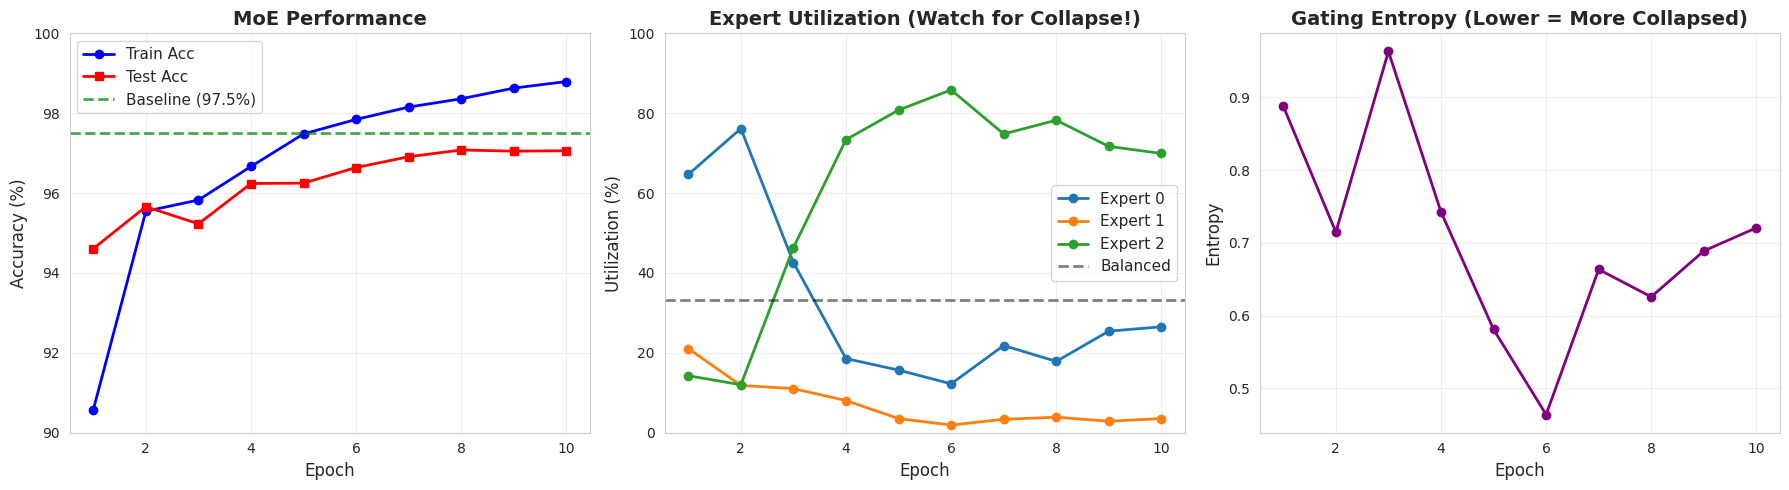


SIMPLE MOE - FINAL SUMMARY

Performance vs Baseline:
   MoE Test Accuracy:     97.06%
   Baseline Accuracy:     97.52%
   Difference:            -0.46%

Expert Utilization:
   Expert 0:  26.5%
   Expert 1:   3.6%
   Expert 2:  69.9%
   Entropy:   0.721

Slight imbalance (normal without load balancing)


Model saved to: /kaggle/working/simple_moe.pth


In [8]:
# ================================================================
# SECTION 8: MAIN EXECUTION
# ================================================================

# Configuration
BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 0.001
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# MoE Configuration
NUM_EXPERTS = 3
EXPERT_HIDDEN = 64  # Smaller than baseline (128)
TOP_K = 1  # Use only the best expert

# Load data
train_loader, test_loader = load_mnist(batch_size=BATCH_SIZE)

# Create MoE model
print("\nBuilding MoE Model...")
model = SimpleMoE(
    input_dim=784,
    num_experts=NUM_EXPERTS,
    expert_hidden=EXPERT_HIDDEN,
    output_dim=10,
    top_k=TOP_K
)
print(f"MoE created with {model.count_parameters():,} parameters")
print(f"Number of experts: {NUM_EXPERTS}")
print(f"Expert capacity: {EXPERT_HIDDEN} hidden units each")

# Train
history = train_moe(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    device=DEVICE
)

# Visualize
plot_moe_analysis(history)

# Summary
print_moe_summary(history, baseline_acc=97.52)  

# Save model
model_path = '/kaggle/working/simple_moe.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'config': {
        'num_experts': NUM_EXPERTS,
        'expert_hidden': EXPERT_HIDDEN,
        'top_k': TOP_K
    }
}, model_path)
print(f"\nModel saved to: {model_path}")